In [1]:
import numpy as np
import pandas as pd
from scipy.sparse.linalg import svds #SVD

# Setup

In [2]:
#Download dataset
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

#Unzip dataset
!unzip ml-latest-small.zip

--2021-09-15 12:39:52--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  --.-KB/s    in 0.1s    

2021-09-15 12:39:52 (6.42 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [3]:
ratings_df = pd.read_csv("/content/ml-latest-small/ratings.csv", sep=",")
ratings_df.head()
#L'index ne commence pas à 1

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
ratings_df.describe()
#Les identifiants de films ne sont pas continus

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [5]:
movies_df = pd.read_csv("/content/ml-latest-small/movies.csv", sep=",")
movies_df.head()
#L'index ne commence pas à 1

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Nettoyage des données

In [6]:
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [7]:
# Définition d'un seuil sur le nombre de notes par utilisateur ==> Count par utilisateur des notes
count_per_user = (ratings_df.groupby(by=['userId'])['rating']
                  .count()
                  .reset_index()
                  .rename(columns={'rating': 'rating_count'}))
count_per_user.describe()

,userId,rating_count
count,610.000000,610.000000
mean,305.500000,165.304918
std,176.236111,269.480584
min,1.000000,20.000000
25%,153.250000,35.000000
50%,305.500000,70.500000
75%,457.750000,168.000000
max,610.000000,2698.000000


Au minimum, chaque utilisateur à au moins 20 notes

In [8]:
# Définition d'un seuil sur le nombre de notes par utilisateur ==> Count par utilisateur des notes
count_per_movie = (ratings_df.groupby(by=['movieId'])['rating']
                  .count()
                  .reset_index()
                  .rename(columns={'rating': 'rating_count'}))
count_per_movie.describe()

,movieId,rating_count
count,9724.000000,9724.000000
mean,42245.024373,10.369807
std,52191.137320,22.401005
min,1.000000,1.000000
25%,3245.500000,1.000000
50%,7300.000000,3.000000
75%,76739.250000,9.000000
max,193609.000000,329.000000


Le nombre minimum de notes sur un film est de 1 : Pas suffisant, donc on filtre

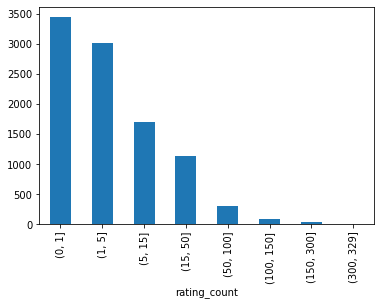

In [9]:
#Plotting
bins_values = [0, 1, 5, 15, 50, 100, 150, 300, count_per_movie['rating_count'].max()]
bins = pd.cut(count_per_movie['rating_count'], bins_values)
groups = count_per_movie.groupby(by=bins)['rating_count'].count()
groups.plot(kind='bar')

En filtrant à 2, on perd presque 3500 films, mais il ne sont pas exploitables

In [10]:
movie_threshold = 2
count_per_movie = count_per_movie[count_per_movie['rating_count'] >= movie_threshold]

In [11]:
count_per_movie

,movieId,rating_count
0,1,215
1,2,110
2,3,52
3,4,7
4,5,49
...,...,...
9690,187541,4
9691,187593,12
9692,187595,5
9695,188301,3


In [12]:
#Construction du df filtré sur les films avec seuil
ratings = pd.merge(count_per_movie, ratings_df, left_on='movieId', right_on='movieId', how='left')

print(f'Proportions de notes conservées : {len(ratings) / len(ratings_df)}')

cols = ['timestamp', 'rating_count'] #Genres
ratings.drop(cols, axis=1, inplace=True)

num_movies = ratings['movieId'].nunique()
print(f'Nombre de films uniques : {num_movies}')

num_users = ratings['userId'].nunique()
print(f'Nombre d\'utilisateurs uniques : {num_users}')


Proportions de notes conservées : 0.965825697171645
Nombre de films uniques : 6278
Nombre d'utilisateurs uniques : 610


In [13]:
#Creation de mapping pour les ids
#Comme on a filtré les données, les id ne sont pas continus, mais keras fonctionne avec des id continus

def generate_id_mappings(ids_list):
  #Dictionnaires qui vont faire coincider des identifiants qui commencent à 0 et qui sont continus, avec les identifiants qui commencent à 1 et qui ne sont pas continus
  userId_map = {new_id: old_id for new_id, old_id in enumerate(ids_list)}
  inverse_userId_map = {old_id: new_id for new_id, old_id in enumerate(ids_list)}
  return userId_map, inverse_userId_map

userId_map, inverse_userId_map = generate_id_mappings(ratings.userId.unique())
movieId_map, inverse_movieId_map = generate_id_mappings(ratings.movieId.unique())

ratings['mUserId'] = ratings['userId'].map(inverse_userId_map)
ratings['mMovieId'] = ratings['movieId'].map(inverse_movieId_map)

In [14]:
ratings

,movieId,userId,rating,mUserId,mMovieId
0,1,1,4.0,0,0
1,1,5,4.0,1,0
2,1,7,4.5,2,0
3,1,15,2.5,3,0
4,1,17,4.5,4,0
...,...,...,...,...,...
97385,188301,50,3.0,17,6276
97386,188301,380,4.0,135,6276
97387,188301,596,4.0,202,6276
97388,189333,184,4.0,609,6277


# Content based recommandation

In [15]:
ratings

,movieId,userId,rating,mUserId,mMovieId
0,1,1,4.0,0,0
1,1,5,4.0,1,0
2,1,7,4.5,2,0
3,1,15,2.5,3,0
4,1,17,4.5,4,0
...,...,...,...,...,...
97385,188301,50,3.0,17,6276
97386,188301,380,4.0,135,6276
97387,188301,596,4.0,202,6276
97388,189333,184,4.0,609,6277


In [16]:
# Films bien notés par l'utilisateur 550
liked_movies = ratings.query('userId == 550 and rating == 5')['movieId']

In [17]:
display(liked_movies)

85432     59315
89417     79132
91266     89745
94258    109487
95597    122904
Name: movieId, dtype: int64

In [18]:
ratings.query('userId == 550 and rating >= 5')

,movieId,userId,rating,mUserId,mMovieId
85432,59315,550,5.0,187,4928
89417,79132,550,5.0,187,5288
91266,89745,550,5.0,187,5471
94258,109487,550,5.0,187,5826
95597,122904,550,5.0,187,5962


In [19]:
movies_df.query('movieId in @liked_movies')

,movieId,title,genres
6743,59315,Iron Man (2008),Action|Adventure|Sci-Fi
7372,79132,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX
7693,89745,"Avengers, The (2012)",Action|Adventure|Sci-Fi|IMAX
8376,109487,Interstellar (2014),Sci-Fi|IMAX
8691,122904,Deadpool (2016),Action|Adventure|Comedy|Sci-Fi


In [20]:
from sklearn.metrics.pairwise import cosine_similarity

movies_genres_df = movies_df.join(movies_df['genres'].str.get_dummies("|"))
movies_genres_df["mMovieId"] = movies_genres_df['movieId'].map(inverse_movieId_map)

movies_genres_df.set_index("mMovieId", inplace=True) #Les mMovieId sont les index
movies_genres_df = movies_genres_df.loc[movies_genres_df.index.dropna()]

cos_sim = cosine_similarity(movies_genres_df.iloc[:,3:])

In [21]:
cos_sim

array([[1.        , 0.77459667, 0.31622777, ..., 0.4472136 , 0.6       ,
        0.25819889],
       [0.77459667, 1.        , 0.        , ..., 0.57735027, 0.51639778,
        0.33333333],
       [0.31622777, 0.        , 1.        , ..., 0.        , 0.31622777,
        0.        ],
       ...,
       [0.4472136 , 0.57735027, 0.        , ..., 1.        , 0.67082039,
        0.57735027],
       [0.6       , 0.51639778, 0.31622777, ..., 0.67082039, 1.        ,
        0.51639778],
       [0.25819889, 0.33333333, 0.        , ..., 0.57735027, 0.51639778,
        1.        ]])

In [22]:
movies_genres_df

,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
mMovieId,,,,,,,,,,,,,,,,,,,,,,,
0.0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1.0,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2.0,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3.0,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4.0,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6273.0,187541,Incredibles 2 (2018),Action|Adventure|Animation|Children,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6274.0,187593,Deadpool 2 (2018),Action|Comedy|Sci-Fi,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6275.0,187595,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [24]:
ironMan_id = 59315
ironMan_mMovieId = inverse_movieId_map[ironMan_id]
ironMan_top5 = np.argsort(cos_sim[ironMan_mMovieId])[-5:][::-1]
ironMan_top5_movieId = [movieId_map[x] for x in ironMan_top5]

movies_df.query('movieId in @ironMan_top5_movieId')

,movieId,title,genres
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
1904,2528,Logan's Run (1976),Action|Adventure|Sci-Fi
2764,3702,Mad Max (1979),Action|Adventure|Sci-Fi
2836,3793,X-Men (2000),Action|Adventure|Sci-Fi
6863,62383,"20,000 Leagues Under the Sea (1916)",Action|Adventure|Sci-Fi


# Factorisation de matrice par SVD (collaborative filtering by model)

En algèbre linéaire, une matrice peut être décomposée en valeurs singulières (SVD) sans perte de données  
-> Une matrice R va être décomposée en une matrice U * sigma * F

Les matrices sont ensuite tronquées par une dimension latente pour en diminuer le volume. La matrice est approximée dans le processus  
-> R devient R_appr = U_trunc * sigma_trunc * F_trunc

In [25]:
from scipy.sparse import csr_matrix #Pour représenter les matrices sparses
from scipy.linalg import sqrtm

R_df = ratings.pivot(index='mUserId', columns='mMovieId', values='rating').fillna(0)
R_df.head()

mMovieId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,6238,6239,6240,6241,6242,6243,6244,6245,6246,6247,6248,6249,6250,6251,6252,6253,6254,6255,6256,6257,6258,6259,6260,6261,6262,6263,6264,6265,6266,6267,6268,6269,6270,6271,6272,6273,6274,6275,6276,6277
mUserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
ratings.head()

,movieId,userId,rating,mUserId,mMovieId
0,1,1,4.0,0,0
1,1,5,4.0,1,0
2,1,7,4.5,2,0
3,1,15,2.5,3,0
4,1,17,4.5,4,0


In [34]:
R = R_df.values #On donne à l'algorithme la matrice, pas le dataframe (np array)

# On normalise les lignes par utilisateur pour se débarasser de leur biais
# On retire leur moyenne de toute leur note, on les rajoutera plus tard aux predictions
user_ratings_mean = np.mean(R, axis=1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [35]:
R_demeaned

array([[ 3.83928003, -0.16071997,  3.83928003, ..., -0.16071997,
        -0.16071997, -0.16071997],
       [ 3.97451418, -0.02548582, -0.02548582, ..., -0.02548582,
        -0.02548582, -0.02548582],
       [ 4.42179038, -0.07820962, -0.07820962, ..., -0.07820962,
        -0.07820962, -0.07820962],
       ...,
       [-0.01338006, -0.01338006, -0.01338006, ..., -0.01338006,
        -0.01338006, -0.01338006],
       [-0.01258363, -0.01258363, -0.01258363, ..., -0.01258363,
        -0.01258363, -0.01258363],
       [-0.06092705, -0.06092705, -0.06092705, ..., -0.06092705,
        -0.06092705,  3.93907295]])

In [36]:
from scipy.sparse.linalg import svds

latent_dimension = 30 #10~50 sont des valeurs communes
U, sigma, Vt = svds(R_demeaned, k=latent_dimension)

print(f"Dimensions de U : {U.shape}")
print(f"Dimensions de sigma : {sigma.shape}")
print(f"Dimensions de Vt : {Vt.shape}")

Dimensions de U : (610, 30)
Dimensions de sigma : (30,)
Dimensions de Vt : (30, 6278)


In [37]:
sigma = np.diag(sigma) #Transforme en matrice (50, 50)
s_root = sqrtm(sigma)

#Représentations latentes des utilisateurs et des films en moindre dimension
Usk = np.dot(U, s_root)
skV = np.dot(s_root, Vt)

#Le produit matriciel de ces matrices (Qui incluent toutes le sdeux sigma ici) permet de prédire les notes
predicted_rating = np.dot(Usk, skV)

#Auxquelles on rajoute les moyennes soustraites tout à l'heure
predicted_rating = predicted_rating + user_ratings_mean.reshape(-1, 1)

In [38]:
#On met tout ça dans un dataframe
preds_df = pd.DataFrame(predicted_rating, columns=R_df.columns)
preds_df.head()

mMovieId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,6238,6239,6240,6241,6242,6243,6244,6245,6246,6247,6248,6249,6250,6251,6252,6253,6254,6255,6256,6257,6258,6259,6260,6261,6262,6263,6264,6265,6266,6267,6268,6269,6270,6271,6272,6273,6274,6275,6276,6277
0,2.351915,1.208532,0.942834,-0.092083,0.103484,2.239626,-0.170853,0.029801,0.120090,1.610097,-0.066627,0.274341,0.264426,0.035810,-0.085605,1.609662,-0.663779,0.547553,0.909777,0.071186,0.241038,0.381301,-0.064187,0.208908,0.456454,-0.233578,0.006028,-0.061367,0.882030,-0.065013,0.031207,2.088471,1.182334,0.142630,0.070658,0.882511,-0.003399,0.047445,0.291117,-0.051278,...,0.051824,0.086246,-0.070363,0.033160,0.017147,0.253433,-0.069150,-0.074909,0.492462,0.030652,-0.084463,-0.244727,0.022016,-0.051246,-0.018191,0.173065,0.030939,-0.085567,-0.108817,0.009199,-0.053761,0.044924,0.128669,-0.026380,0.163861,0.032647,-0.055391,-0.082226,-0.100525,0.137567,0.012057,-0.022731,0.004914,-0.038414,0.031168,-0.010008,-0.224511,0.209529,0.089692,-0.012569
1,1.384288,0.938192,0.220267,0.100593,0.412090,0.588297,0.391021,0.138777,-0.013942,1.125239,0.923320,0.000415,0.085218,0.231436,0.199842,0.488653,0.684354,0.090787,0.554159,0.028653,1.119598,0.501770,0.194367,0.130935,0.754556,0.182135,0.076537,0.131589,0.133001,0.002865,0.388642,1.103458,1.740854,0.865083,-0.021742,1.042519,-0.014471,0.152751,-0.021673,0.092568,...,-0.043426,0.012046,-0.021223,-0.012015,0.029222,-0.036461,-0.047443,-0.026995,0.040148,-0.024622,-0.041851,-0.019380,-0.026689,-0.017802,0.011731,-0.000510,-0.029654,-0.019751,-0.061971,-0.010150,-0.045163,-0.004696,-0.006744,0.014211,-0.004722,0.014431,-0.007232,0.009560,-0.008521,0.002448,0.002654,-0.006475,-0.022520,-0.035318,-0.010858,-0.005549,-0.044526,0.014804,0.014399,-0.016930
2,2.002026,0.977438,-0.052420,-0.011957,0.087057,0.697373,0.046487,-0.095562,-0.021765,1.167110,0.356505,-0.124693,0.046074,-0.018115,-0.030696,-0.037459,0.186084,-0.108752,0.343399,0.058803,0.274436,-0.018804,0.037239,-0.118506,0.312433,-0.121810,-0.062644,0.025589,-0.068094,-0.024651,-0.016221,1.388833,0.990760,0.208505,0.014030,0.120316,0.012475,0.046875,-0.109233,-0.041410,...,-0.040590,0.002798,-0.002818,-0.004607,0.069169,-0.026477,-0.025583,-0.002466,-0.113873,-0.085228,0.001324,0.138443,-0.082074,0.006882,-0.023978,0.023438,-0.082053,0.177493,-0.091835,0.017139,-0.034834,-0.054147,-0.075894,-0.019216,0.067579,0.058242,-0.013414,0.037371,0.084188,0.015393,-0.016024,0.073083,0.068788,-0.029550,0.003572,-0.003008,0.144080,0.036941,0.044609,0.014063
3,2.160258,0.630899,0.013902,-0.035042,-0.015761,0.347947,0.183779,-0.003291,0.126805,0.319518,-0.245736,0.038941,0.100014,0.000334,0.039735,-0.150165,0.138058,-0.089944,-0.026393,0.014818,-0.554350,-0.082285,-0.051184,0.165205,0.180609,-0.108145,-0.005761,0.077916,-0.090491,0.045653,0.014401,1.162427,0.577892,0.272844,-0.026167,-0.098852,-0.002777,0.003669,-0.040663,-0.031042,...,0.354230,-0.029860,0.063869,0.087748,0.101189,0.364468,-0.017610,0.131515,0.224710,0.018345,0.116623,0.324743,0.040628,0.060217,-0.021937,0.180705,0.009922,0.414861,0.255817,0.058495,-0.015030,0.064009,0.147833,-0.029647,0.033748,0.046788,0.163282,0.012754,0.022219,0.046146,-0.001217,0.071254,0.089959,0.062353,0.020883,0.093934,0.406460,0.168191,0.023145,0.036628
4,2.215817,-0.001582,-0.064735,0.009133,-0.092200,1.083485,-0.103224,0.067283,0.091655,0.753369,-0.015110,0.147853,0.011733,0.092327,0.016210,0.782601,0.148105,0.131440,0.021597,0.169907,0.058340,0.116175,0.061805,0.163616,0.650451,-0.076991,-0.033538,-0.025434,0.652081,-0.122669,0.175459,1.634742,0.228080,0.620864,-0.028264,-0.114308,-0.008492,0.048818,0.050413,-0.014766,...,0.145907,-0.010534,-0.056307,0.016171,-0.039667,-0.024402,-0.023061,-0.014291,0.214649,-0.015365,-0.044361,0.145741,0.025341,-0.010745,-0.028612,0.052710,-0.007954,0.002140,0.047441,0.061743,-0.030210,-0.004469,0.059729,-0.033918,-0.137777,-0.039538,0.122627,-0.088012,

In [39]:
def recommend_moviesSVD(predictions_df, userId, movies_df, original_ratings_df, num_recommendations=10):
  #Ordonner les prédictions pour l'utilisateur donné
  mUserId = inverse_userId_map[userId]
  sorted_user_predictions = preds_df.iloc[mUserId].sort_values(ascending=False)

  #Récupérer les notes déjà données par l'utilisateur avec les titres de films
  user_data = original_ratings_df[original_ratings_df.mUserId == (mUserId)]
  user_full = (user_data.merge(movies_df, how='left', left_on='movieId', right_on='movieId')
                                                                      .sort_values(['rating'], ascending=False)
                                                                      )[['movieId', 'title', 'genres']]

  print(f'\n\n############# L\'utilisateur {userId} a deja noté {user_full.shape[0]} films')

  #Recommander les films les mieux notés par encore vus
  recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])].
      merge(pd.DataFrame(sorted_user_predictions).reset_index(), how='left',
              left_on='mMovieId',
              right_on='mMovieId').
      rename(columns={mUserId: 'Predictions'}).
      sort_values('Predictions', ascending=False).
              iloc[:num_recommendations, :-1]
      )
  return user_full, recommendations

In [40]:
#Maintenant tous les dataframes contiennent les 2 colonnes d'identifiants mappés
movies_df['mMovieId'] = movies_df['movieId'].map(inverse_movieId_map)

# Faire des prédictions pour les 10 premiers utilisateurs
for user in list(inverse_userId_map.keys())[:3]:
  already_rated, predictions = recommend_moviesSVD(preds_df, user, movies_df, ratings, 10)
  display(already_rated.head(10))
  print('\n###### Films recommandés :')
  display(predictions)



############# L'utilisateur 1 a deja noté 231 films


,movieId,title,genres
230,5060,M*A*S*H (a.k.a. MASH) (1970),Comedy|Drama|War
184,2872,Excalibur (1981),Adventure|Fantasy
89,1291,Indiana Jones and the Last Crusade (1989),Action|Adventure
90,1298,Pink Floyd: The Wall (1982),Drama|Musical
189,2948,From Russia with Love (1963),Action|Adventure|Thriller
188,2947,Goldfinger (1964),Action|Adventure|Thriller
187,2944,"Dirty Dozen, The (1967)",Action|Drama|War
185,2899,Gulliver's Travels (1939),Adventure|Animation|Children
97,1517,Austin Powers: International Man of Mystery (1...,Action|Adventure|Comedy
107,1732,"Big Lebowski, The (1998)",Comedy|Crime



###### Films recommandés :


,movieId,title,genres,mMovieId
615,858,"Godfather, The (1972)",Crime|Drama,580.0
736,1036,Die Hard (1988),Action|Crime|Thriller,698.0
475,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,452.0
831,1200,Aliens (1986),Action|Adventure|Horror|Sci-Fi,790.0
974,1387,Jaws (1975),Action|Horror,948.0
844,1221,"Godfather: Part II, The (1974)",Crime|Drama,810.0
1329,1968,"Breakfast Club, The (1985)",Comedy|Drama,1267.0
1109,1610,"Hunt for Red October, The (1990)",Action|Adventure|Thriller,1071.0
2008,2918,Ferris Bueller's Day Off (1986),Comedy,1910.0
965,1374,Star Trek II: The Wrath of Khan (1982),Action|Adventure|Sci-Fi|Thriller,938.0




############# L'utilisateur 5 a deja noté 44 films


,movieId,title,genres
37,590,Dances with Wolves (1990),Adventure|Drama|Western
30,475,In the Name of the Father (1993),Drama
32,527,Schindler's List (1993),Drama|War
6,58,"Postman, The (Postino, Il) (1994)",Comedy|Drama|Romance
41,596,Pinocchio (1940),Animation|Children|Fantasy|Musical
40,595,Beauty and the Beast (1991),Animation|Children|Fantasy|Musical|Romance|IMAX
11,247,Heavenly Creatures (1994),Crime|Drama
39,594,Snow White and the Seven Dwarfs (1937),Animation|Children|Drama|Fantasy|Musical
17,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
16,290,Once Were Warriors (1994),Crime|Drama



###### Films recommandés :


,movieId,title,genres,mMovieId
291,356,Forrest Gump (1994),Comedy|Drama|Romance|War,280.0
471,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,455.0
387,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,372.0
124,161,Crimson Tide (1995),Drama|Thriller|War,121.0
128,165,Die Hard: With a Vengeance (1995),Action|Crime|Thriller,125.0
308,377,Speed (1994),Action|Romance|Thriller,299.0
367,454,"Firm, The (1993)",Drama|Thriller,353.0
38,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,43.0
405,500,Mrs. Doubtfire (1993),Comedy|Drama,387.0
350,434,Cliffhanger (1993),Action|Adventure|Thriller,338.0




############# L'utilisateur 7 a deja noté 152 films


,movieId,title,genres
40,2019,Seven Samurai (Shichinin no samurai) (1954),Action|Adventure|Drama
8,466,Hot Shots! Part Deux (1993),Action|Comedy|War
26,1219,Psycho (1960),Crime|Horror
28,1240,"Terminator, The (1984)",Action|Sci-Fi|Thriller
14,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
59,3869,"Naked Gun 2 1/2: The Smell of Fear, The (1991)",Comedy
30,1270,Back to the Future (1985),Adventure|Comedy|Sci-Fi
9,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
32,1584,Contact (1997),Drama|Sci-Fi
6,356,Forrest Gump (1994),Comedy|Drama|Romance|War



###### Films recommandés :


,movieId,title,genres,mMovieId
1895,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,1712.0
876,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,788.0
3773,5418,"Bourne Identity, The (2002)",Action|Mystery|Thriller,3178.0
4268,6377,Finding Nemo (2003),Adventure|Animation|Children|Comedy,3508.0
959,1291,Indiana Jones and the Last Crusade (1989),Action|Adventure,878.0
1151,1580,Men in Black (a.k.a. MIB) (1997),Action|Comedy|Sci-Fi,1044.0
1126,1527,"Fifth Element, The (1997)",Action|Adventure|Comedy|Sci-Fi,1023.0
1462,2028,Saving Private Ryan (1998),Action|Drama|War,1321.0
2920,3996,"Crouching Tiger, Hidden Dragon (Wo hu cang lon...",Action|Drama|Romance,2545.0
1255,1721,Titanic (1997),Drama|Romance,1137.0


In [41]:
#Factorisation de toiut ça
def compute_svd(R_df, latent_dimension=30):
  R = R_df.values
  user_ratings_mean = np.mean(R, axis=1)
  R_demeaned = R - user_ratings_mean.reshape(-1, 1)
  U, sigma, Vt = svds(R_demeaned, k=latent_dimension)
  sigma = np.diag(sigma)
  s_root = sqrtm(sigma)
  Usk = np.dot(U, s_root)
  skV = np.dot(s_root, Vt)
  predicted_rating = np.dot(Usk, skV)
  predicted_rating = predicted_rating + user_ratings_mean.reshape(-1, 1)

  return pd.DataFrame(predicted_rating, columns=R_df.columns)

## Définition ensemble d'apprentissage et de test

In [42]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(ratings, test_size=0.3, random_state=42)

## Optimisation des variables (Grid search)

On utilisera l'erreur quadratique moyenne (RMSE) qu'on minimisera dans une fonction de cout

In [45]:
#Fonction de cout naive
def rmse(true, pred):
  x = true - pred #erreur
  return sum([xi*xi for xi in x])/len(x)

#Dimensions des représentations latentes à tester
latent_dims = [30, 50, 80, 120, 150]

#Optimisation
for latent_dim in latent_dims:
  predictions = compute_svd(train_df, latent_dimension=latent_dim)
  sparse_predictions = predictions.stack().reset_index(name='pred_rating').rename(columns={'level_0': 'mUserId', 'level_1': 'mMovieId'})
  sparse_predictions = sparse_predictions.merge(test_df, left_on=['mUserId', 'mMovieId'], right_on=['mUserId', 'mMovieId'], how='right')

  print(f"Pour latent_dimension = {latent_dim}, rmse = {rmse(sparse_predictions['rating'], sparse_predictions['pred_rating'])}")

Pour latent_dimension = 30, rmse = 4.856243973042969
Pour latent_dimension = 50, rmse = 3.9474979784263193
Pour latent_dimension = 80, rmse = 2.9540275763180026
Pour latent_dimension = 120, rmse = 2.0833213557837316
Pour latent_dimension = 150, rmse = 1.5997300766558586
